<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Py_trodes/PyTrodes_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
New Python Based Pipeline for Trodes
"""

'\nNew Python Based Pipeline for Trodes\n'

In [2]:
""" Generate RAW_LFP Binaries from *.rec files"""
""" Import RAW_LFP """
""" Import XY_position Data """
""" Find Ripples """
""" Map Channels """
""" Finde APs """
""" Find IIS """


' Find IIS '

In [3]:
import os
import subprocess
import numpy as np
trodes_dat_reader_loc = r'C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\Resources\TrodesToPython'
os.chdir(trodes_dat_reader_loc)
import readTrodesExtractedDataFile3 as trodes



In [4]:
""" Generate RAW_LFP Binaries from *.rec files"""
dest_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA'
export_func_location = r'C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\trodesexport.exe'
dot_rec_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\Test_Emily\AngelfoodCake01\AngelfoodCake01.rec'
full_cmd_raw = ' '.join([export_func_location, '-raw',
                    '-rec ', dot_rec_file_loc,
                    '-userawrefs', str(0),
                    '-outputdirectory', dest_dir])
# export_report = subprocess.run(full_cmd_raw)



In [6]:
""" Import RAW_LFP """
os.chdir(r'\C:\Users\dennis.tabuena\Desktop\Temp_data')

dot_dat_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA\AngelfoodCake01.raw\AngelfoodCake01.raw_group0.dat'
dot_dat_data = trodes.readTrodesExtractedDataFile(dot_dat_file_loc)
voltage_scaling = float(dot_dat_data['voltage_scaling'])



num_samples = dot_dat_data['data']['voltage'].shape[0]
num_channels = dot_dat_data['data']['voltage'].shape[1]

filename = 'temp_disk_nparray.dat'
mmap_array = np.memmap(filename, dtype='float16', mode='w+', shape=(num_samples,num_channels))
mmap_array = dot_dat_data['data']['voltage'].astype('float16')
mmap_array*=voltage_scaling


In [7]:
mmap_array.shape

(131536403, 32)

In [51]:
mmap_array.shape[1]

32

Text(0.5, 0, 'Time (s)')

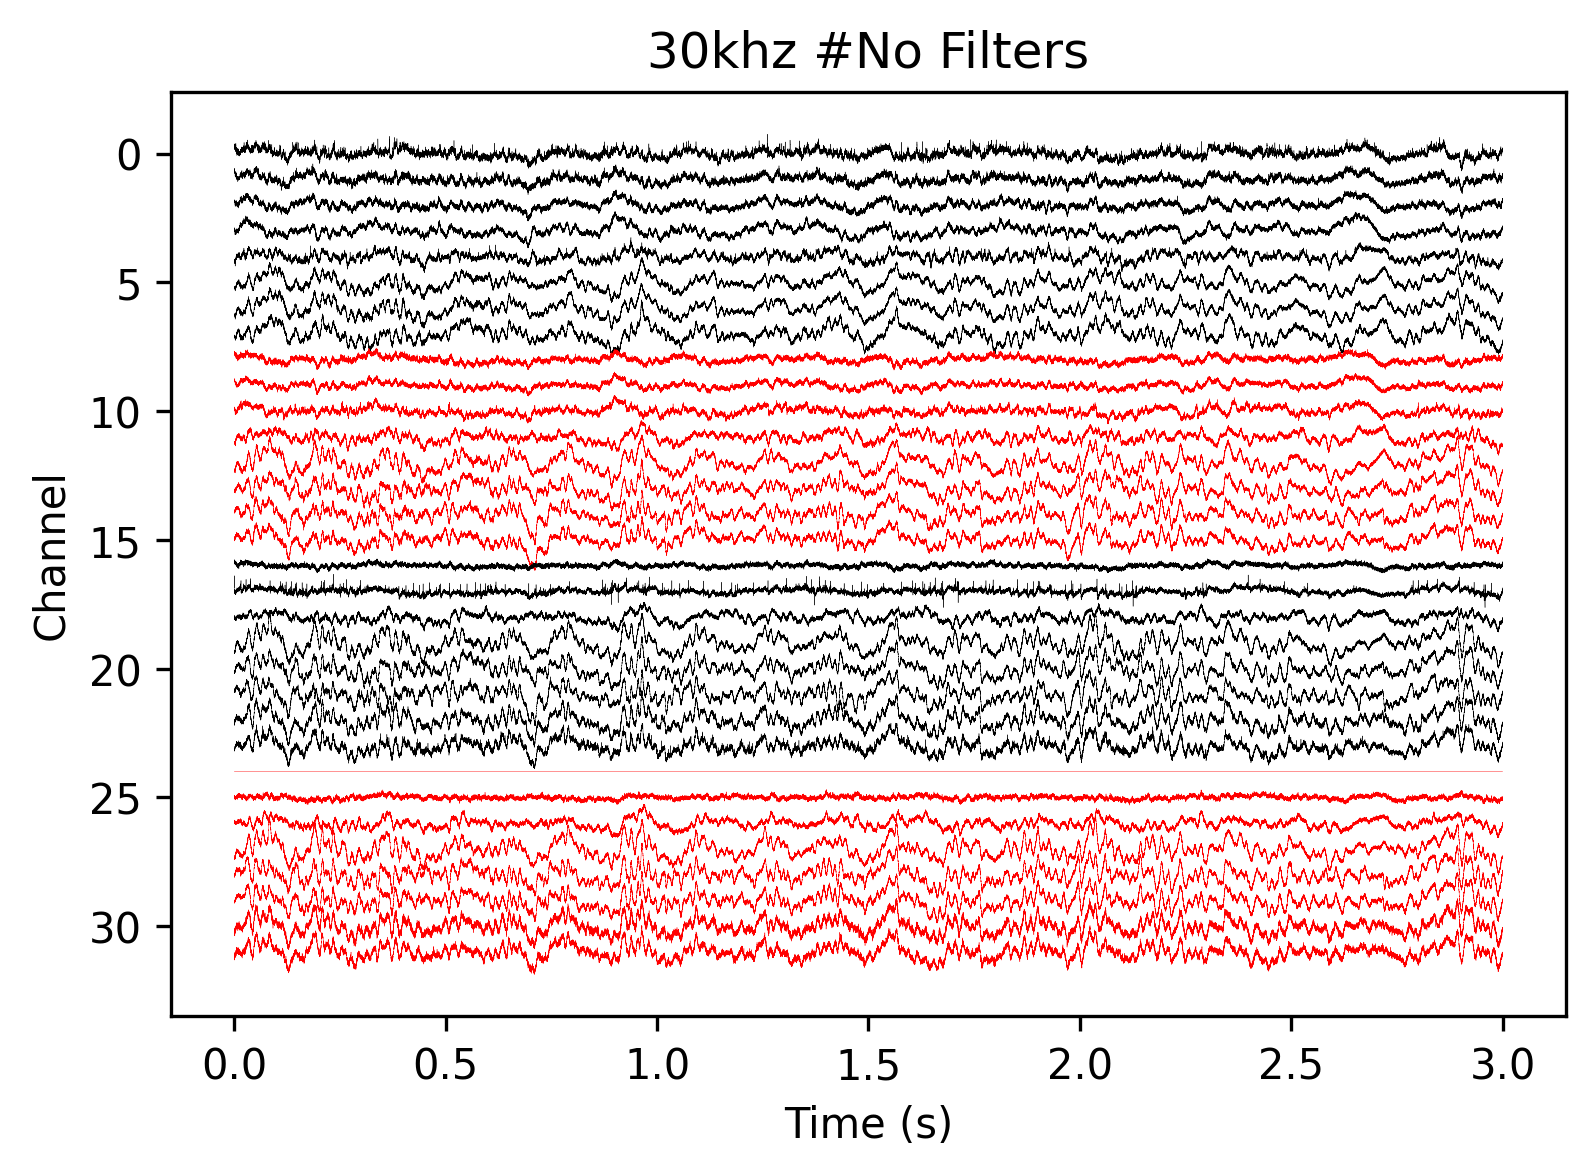

In [155]:
SR = 30000
x = np.random.randint(0,mmap_array.shape[0])
t_wind  = [x,x+3*SR]
t_ind = np.arange(t_wind[0],t_wind[1])

from matplotlib import pyplot as plt
v_samp = mmap_array[t_ind,:]
v_samp = v_samp / np.max(np.abs(v_samp),axis=0) *.75
ch = np.arange(0,32)+1
v_samp = (v_samp.transpose()-v_samp[:,24]).transpose()

colors = ['k']*8 + ['r']*8 + ['k']*8 + ['r']*8
time_sec = (t_ind-t_ind[0])/SR
fig,ax = plt.subplots(figsize=(6,4),dpi=300)
for ch in np.arange(v_samp.shape[1]):
    _ = ax.plot(time_sec,v_samp[:,ch]+ch,linewidth=.1,color = colors[ch])
ax.invert_yaxis()
ax.set_title('30khz #No Filters')
ax.set_ylabel('Channel')
ax.set_xlabel('Time (s)')

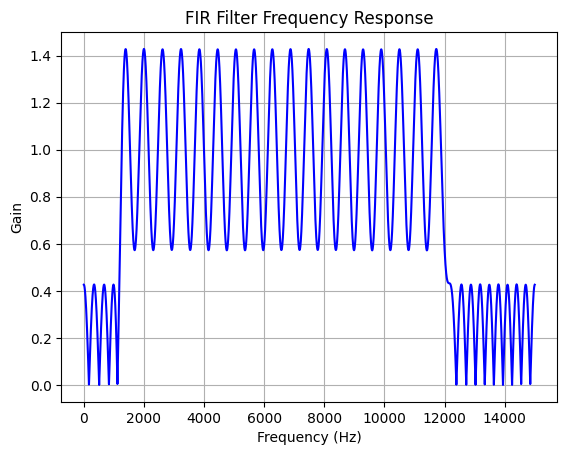

In [165]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt


# Sampling frequency
fs = 30000  # 30 kHz

# Desired passband frequencies (150-250 Hz)
passband = [600, 6000]

# Stopband frequencies (for sharper transition)
stopband = [590, 6100]

# Normalized frequencies (Nyquist frequency is half the sampling rate)
nyq = fs / 2
passband_norm = [f / nyq for f in passband]
stopband_norm = [f / nyq for f in stopband]
cutoff = [f / nyq for f in passband]

# Design parameters
desired_attenuation = 120  # Desired stopband attenuation in dB
ripple = 1  # Passband ripple in dB

# Estimate filter order
numtaps = 101  # Number of filter coefficients (adjust as needed)
fir_coeff = signal.firwin(numtaps, cutoff, pass_zero=False, fs=fs)

# Design the FIR filter using the Parks-McClellan algorithm
fir_coeff = signal.remez(numtaps, [0, stopband_norm[0], passband_norm[0], passband_norm[1], stopband_norm[1], 0.5], [0, 1, 0])



# Plot the frequency response of the filter
w, h = signal.freqz(fir_coeff, worN=8000)
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.title('FIR Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid()
plt.show()

Text(0.5, 0, 'Time (s)')

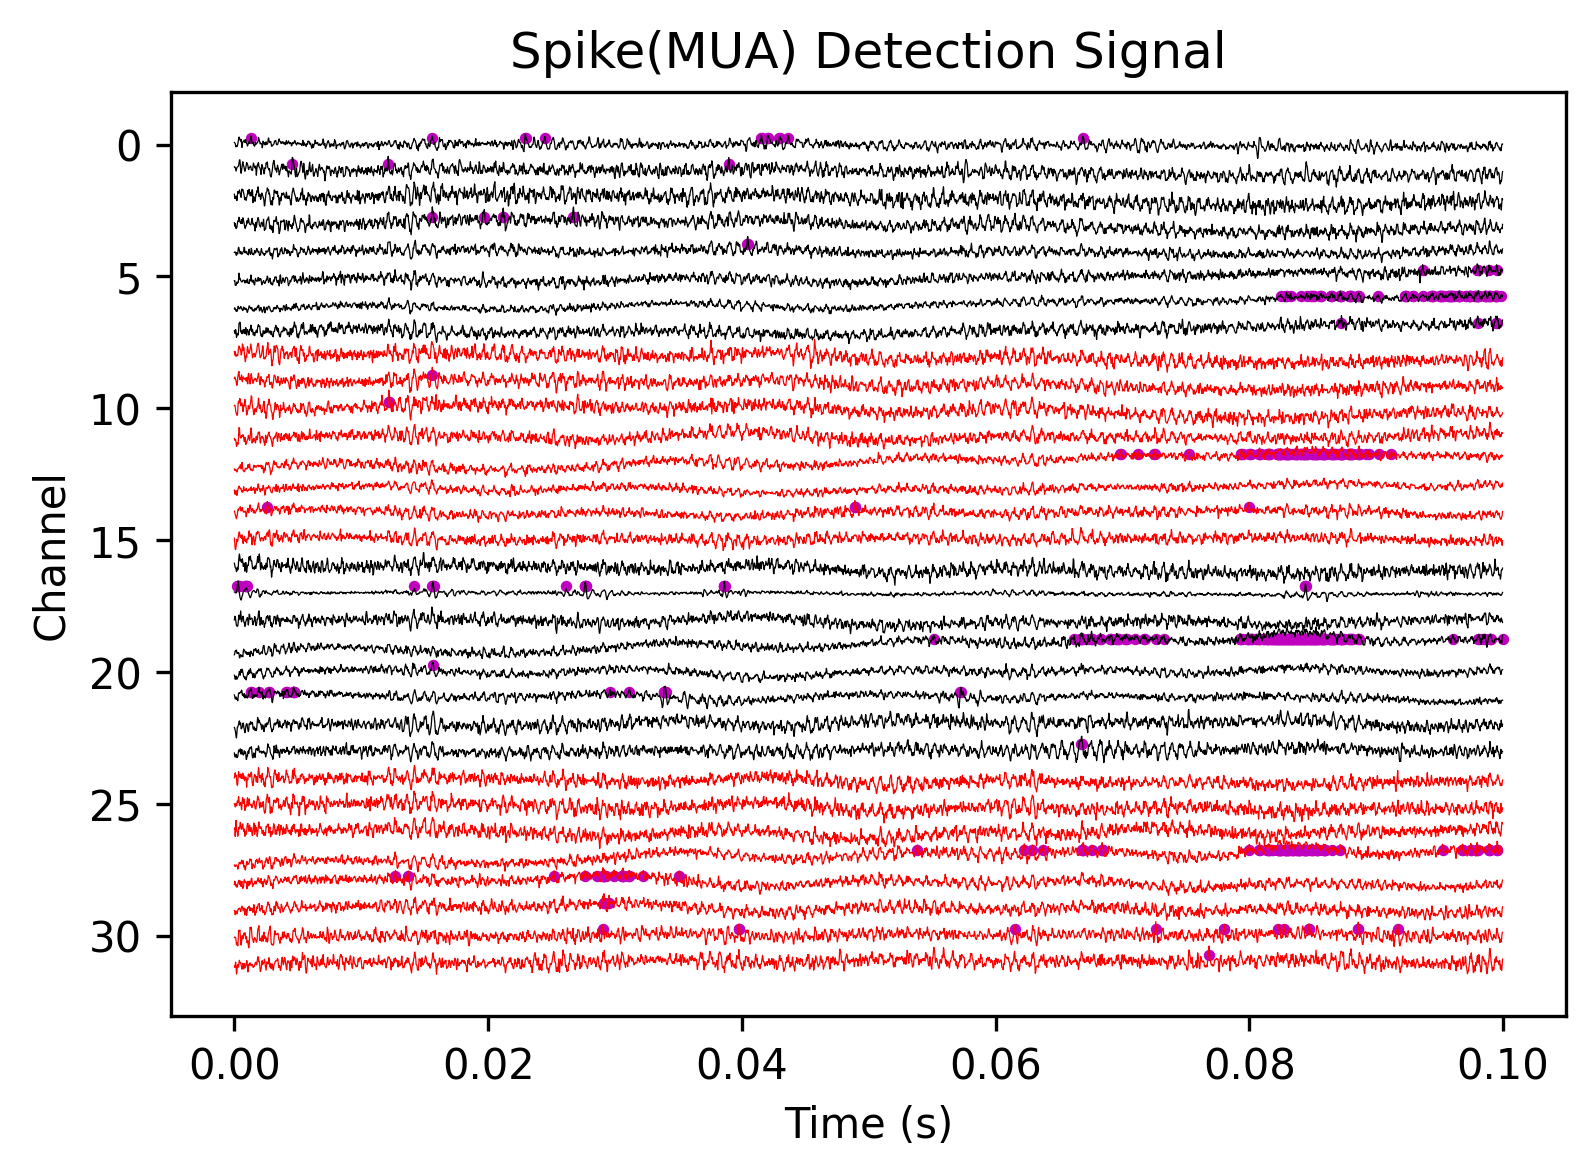

In [196]:
# Apply the FIR filter using filtfilt for zero-phase filtering across all channels
filtered_data = signal.filtfilt(fir_coeff, 1.0, mmap_array[t_ind,:], axis=0)
# filtered_data = mmap_array[t_ind,:]
# filtered_data=(filtered_data.transpose() - filtered_data[:,24]).transpose()
spike_bool = filtered_data<-70


fig,ax = plt.subplots(figsize=(6,4),dpi=300)

filtered_data = filtered_data/np.max(np.abs(filtered_data),axis=0) * .8

# Filtered signal
for ch in np.arange(filtered_data.shape[1]):
    ax.plot(time_sec[:3000],filtered_data[:3000,ch]+ch,linewidth=.3,color = colors[ch])
    spike_times = time_sec[:3000][spike_bool[:3000,ch]]
    plt.scatter( spike_times,np.ones_like( spike_times)*ch+-.25,s=3,marker='o',color='m'  )
    ax.set_title('Spike(MUA) Detection Signal')
ax.invert_yaxis()
ax.set_ylabel('Channel')
ax.set_xlabel('Time (s)')
